# **Importing Libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [3]:
#Import tensorflow and keras modules
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras_flops import get_flops
import tensorflow as tf

#Import other modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talos
import math
import pickle
import os
%matplotlib inline

In [4]:
#Save Model Function
def save_m(file, model):
    if not os.path.exists(file):
        os.makedirs(file)

    model.save_weights(file+'/model.h5')
    model_json = model.to_json()
    with open(file + "/model.json", "w") as json_file:
        json_file.write(model_json)

#Save History Function
def save_h(file, history):
    if not os.path.exists(file):
        os.makedirs(file)

    with open(file + '/' + 'model.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)

#Load Model Function
def load_m(file):
	if not os.path.exists(file) and file != 'EnsembleModel':
		print("\n[ERROR] Model path '" + file +  "' does not exist.")
		exit()

	with open(file + "/model.json", "r") as json_file:
		model = json_file.read()
		model = model_from_json(model)
		model.load_weights(file+'/model.h5')
		return model

#Load History Function
def load_h(file):
    with open(file + '/' + 'model.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

#Get data from generator function
def get_data(generator, nb_samples):  
    from tqdm.notebook import tqdm
    x = []
    y = []

    for i in tqdm(range(math.ceil(nb_samples/BATCH_SIZE))):
        x.extend(generator[i][0])
        y.extend(generator[i][1])

    x = np.array(x)
    y = np.array(y)
    return x, y

#Create generator from data function
def get_generator(x, y, preprocess_input, shuffle=True):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen = datagen.flow(x, y, batch_size=BATCH_SIZE, shuffle=shuffle)
    return datagen

# **Loading Data**

In [5]:
#Define Constants
IMAGE_SIZE = (256, 256)
MODEL_INPUT = Input(shape=(256, 256, 3))
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

#Data paths
TRAIN_DATA_PATH = 'ds/train/'
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model path
DIST_STUDENT_MODEL_PATH = 'models/Distilled_Student_Models/'
NORMAL_STUDENT_MODEL_PATH = 'models/Student_Models/'
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

TEACHER_NAME = 'EfficientNetB7'
STUDENT_NAME = 'KD-MobileNetV2'

In [ ]:
#Create Generator from datapath
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(TRAIN_DATA_PATH, 
                                                    target_size=IMAGE_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator = datagen.flow_from_directory(VAL_DATA_PATH, 
                                                        target_size=IMAGE_SIZE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical',
                                                        shuffle=False)

test_generator = datagen.flow_from_directory(TEST_DATA_PATH, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  shuffle=False)

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)
num_classes= len(train_generator.class_indices)

print('NUMBER OF TRAIN SAMPLES:', nb_train_samples)
print('NUMBER OF VALIDATION SAMPLES:',nb_validation_samples)
print('NUMBER OF TEST SAMPLES:',nb_test_samples)
print('TOTAL CLASSES:', num_classes)

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
NUMBER OF TRAIN SAMPLES: 1990
NUMBER OF VALIDATION SAMPLES: 1194
NUMBER OF TEST SAMPLES: 796
TOTAL CLASSES: 199


# **Knowledge Distillation**

**KD Class**

In [ ]:
class KDistiller(Model):
    def __init__(self, student, teacher):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha,
        temperature,
    ):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_preds = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_preds)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics 
        self.compiled_metrics.update_state(y, student_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'combined_loss':loss}
        )

        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_preds = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_preds)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model**

In [ ]:
# Load the teacher
def get_teacher(directory):
    model = load_m(directory)
    return model

print("TEACHER MODEL\n\n\n")
get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME).summary()

TEACHER MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 199)               509639    
Total params: 64,607,326
Trainable params: 64,296,599
Non-trainable params: 310,727
_________________________________________________________________


**Student Model**

In [ ]:
#Create the student
def get_student():
    transfer = mobilenet_v2.MobileNetV2(include_top = False, weights = 'imagenet', input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    gap2D = GlobalAveragePooling2D()(transfer.layers[-1].output)
    drop = Dropout(0.5)(gap2D)
    classifier = Dense(199)(drop)
    
    model = Model(inputs = transfer.inputs, outputs = classifier)
    model.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

    return model

print("STUDENT MODEL\n\n\n")
get_student().summary()

STUDENT MODEL



9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
______________

**Training Student With KD**

In [ ]:
#Get training data in x, y format
print("Loading Training Data")
x_train, y_train = get_data(train_generator, nb_train_samples)

print("Loading Validation Data")
x_val, y_val = get_data(validation_generator, nb_validation_samples)

print("Loading Testing Data")
x_test, y_test = get_data(test_generator, nb_test_samples)

Loading Training Data


  0%|          | 0/498 [00:00<?, ?it/s]

Loading Validation Data


  0%|          | 0/299 [00:00<?, ?it/s]

Loading Testing Data


  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
# Distill teacher to student
p = {
    'temperature':[2, 3, 5, 10],
    'alpha':[0.1, 0.3, 0.5] 
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    #Get teacher and student model                
    teacher = get_teacher(TEACHER_MODEL_PATH  + TEACHER_NAME)
    student = get_student()

    #Create Knowledge distiller
    distiller = KDistiller(student=student, teacher=teacher)

    #Compile Knowledge distiller
    distiller.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE),
        metrics=[CategoricalAccuracy()],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    #Get train and val generator
    train_generator = get_generator(x_train, y_train, mobilenet_v2.preprocess_input)
    validation_generator = get_generator(x_val, y_val, mobilenet_v2.preprocess_input)

    #Training
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples// BATCH_SIZE,
                                        validation_steps = nb_validation_samples// BATCH_SIZE,
                                        epochs=EPOCHS
                                      )

    return distiller_history, distiller.student

scan_object = talos.Scan(x_train, y_train, experiment_name=STUDENT_NAME+'exp', x_val=x_val, y_val=y_val, model=distiller_model, params=p)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Epoch 1/30
497/497 [==============================] - 79s 141ms/step - categorical_accuracy: 0.0106 - student_loss: 5.3631 - distillation_loss: 0.0298 - combined_loss: 0.5631 - val_categorical_accuracy: 0.0101 - val_student_loss: 6.3390
Epoch 2/30
497/497 [==============================] - 68s 137ms/step - categorical_accuracy: 0.0297 - student_loss: 5.0294 - distillation_loss: 0.0248 - combined_loss: 0.5253 - val_categorical_accuracy: 0.0243 - val_student_loss: 5.5848
Epoch 3/30
497/497 [==============================] - 74s 148ms/step - categorical_accuracy: 0.1284 - student_loss: 4.4126 - distillation_loss: 0.0433 - combined_loss: 0.4803 - val_categorical_accuracy: 0.1049 - val_student_loss: 4.3935
Epoch 4/30
497/497 [==============================] - 73s 147ms/step - categorical_accuracy: 0.4204 - student_loss: 3.5222 - distillation_loss: 0.0710 - combined_loss: 0.4161 - val_categorical_accuracy: 0.4379 - val_student_loss: 4.1475
Epoch 5/30
497/497 [==============================] 

  8%|██████▌                                                                        | 1/12 [40:16<7:22:58, 2416.26s/it]

Epoch 1/30
497/497 [==============================] - 91s 169ms/step - categorical_accuracy: 0.0076 - student_loss: 5.3755 - distillation_loss: 0.0220 - combined_loss: 0.5574 - val_categorical_accuracy: 0.0059 - val_student_loss: 5.7090
Epoch 2/30
497/497 [==============================] - 83s 167ms/step - categorical_accuracy: 0.0453 - student_loss: 4.9393 - distillation_loss: 0.0202 - combined_loss: 0.5121 - val_categorical_accuracy: 0.0445 - val_student_loss: 5.0133
Epoch 3/30
497/497 [==============================] - 84s 168ms/step - categorical_accuracy: 0.2054 - student_loss: 4.0478 - distillation_loss: 0.0396 - combined_loss: 0.4404 - val_categorical_accuracy: 0.2844 - val_student_loss: 4.6799
Epoch 4/30
497/497 [==============================] - 84s 169ms/step - categorical_accuracy: 0.5040 - student_loss: 2.8797 - distillation_loss: 0.0651 - combined_loss: 0.3465 - val_categorical_accuracy: 0.4832 - val_student_loss: 3.0740
Epoch 5/30
497/497 [==============================] 

 17%|████████████▊                                                                | 2/12 [1:17:27<6:24:34, 2307.48s/it]

Epoch 1/30
497/497 [==============================] - 79s 146ms/step - categorical_accuracy: 0.0106 - student_loss: 5.3670 - distillation_loss: 0.0109 - combined_loss: 0.5465 - val_categorical_accuracy: 0.0126 - val_student_loss: 5.8203
Epoch 2/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.0896 - student_loss: 4.5942 - distillation_loss: 0.0146 - combined_loss: 0.4725 - val_categorical_accuracy: 0.1317 - val_student_loss: 4.6990
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3515 - student_loss: 3.2406 - distillation_loss: 0.0298 - combined_loss: 0.3509 - val_categorical_accuracy: 0.3893 - val_student_loss: 3.2140
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6551 - student_loss: 2.0444 - distillation_loss: 0.0433 - combined_loss: 0.2434 - val_categorical_accuracy: 0.5713 - val_student_loss: 2.3316
Epoch 5/30
497/497 [==============================] 

 25%|███████████████████▎                                                         | 3/12 [1:53:31<5:36:17, 2241.91s/it]

Epoch 1/30
497/497 [==============================] - 78s 145ms/step - categorical_accuracy: 0.0181 - student_loss: 5.3967 - distillation_loss: 0.0033 - combined_loss: 0.5427 - val_categorical_accuracy: 0.0059 - val_student_loss: 5.2350
Epoch 2/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.0967 - student_loss: 4.5413 - distillation_loss: 0.0047 - combined_loss: 0.4583 - val_categorical_accuracy: 0.1133 - val_student_loss: 4.5365
Epoch 3/30
497/497 [==============================] - 72s 145ms/step - categorical_accuracy: 0.3510 - student_loss: 3.1292 - distillation_loss: 0.0094 - combined_loss: 0.3214 - val_categorical_accuracy: 0.4421 - val_student_loss: 2.9013
Epoch 4/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.6410 - student_loss: 1.9362 - distillation_loss: 0.0141 - combined_loss: 0.2063 - val_categorical_accuracy: 0.6250 - val_student_loss: 1.3921
Epoch 5/30
497/497 [==============================] 

 33%|█████████████████████████▋                                                   | 4/12 [2:29:29<4:54:29, 2208.70s/it]

Epoch 1/30
497/497 [==============================] - 79s 145ms/step - categorical_accuracy: 0.0086 - student_loss: 5.3562 - distillation_loss: 0.0527 - combined_loss: 1.6437 - val_categorical_accuracy: 0.0101 - val_student_loss: 6.2549
Epoch 2/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.0765 - student_loss: 4.7055 - distillation_loss: 0.0699 - combined_loss: 1.4606 - val_categorical_accuracy: 0.1158 - val_student_loss: 4.6438
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3228 - student_loss: 3.4622 - distillation_loss: 0.1487 - combined_loss: 1.1428 - val_categorical_accuracy: 0.3314 - val_student_loss: 3.6407
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6425 - student_loss: 2.2262 - distillation_loss: 0.2285 - combined_loss: 0.8278 - val_categorical_accuracy: 0.5805 - val_student_loss: 3.0143
Epoch 5/30
497/497 [==============================] 

 42%|████████████████████████████████                                             | 5/12 [3:05:30<4:15:40, 2191.45s/it]

Epoch 1/30
497/497 [==============================] - 79s 146ms/step - categorical_accuracy: 0.0131 - student_loss: 5.3467 - distillation_loss: 0.0311 - combined_loss: 1.6258 - val_categorical_accuracy: 0.0176 - val_student_loss: 5.1502
Epoch 2/30
497/497 [==============================] - 72s 145ms/step - categorical_accuracy: 0.0932 - student_loss: 4.6067 - distillation_loss: 0.0445 - combined_loss: 1.4132 - val_categorical_accuracy: 0.1342 - val_student_loss: 3.6710
Epoch 3/30
497/497 [==============================] - 72s 145ms/step - categorical_accuracy: 0.3379 - student_loss: 3.1781 - distillation_loss: 0.0943 - combined_loss: 1.0195 - val_categorical_accuracy: 0.3884 - val_student_loss: 3.0534
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6324 - student_loss: 2.0379 - distillation_loss: 0.1369 - combined_loss: 0.7072 - val_categorical_accuracy: 0.5327 - val_student_loss: 1.5677
Epoch 5/30
497/497 [==============================] 

 50%|██████████████████████████████████████▌                                      | 6/12 [3:41:37<3:38:19, 2183.33s/it]

Epoch 1/30
497/497 [==============================] - 79s 146ms/step - categorical_accuracy: 0.0096 - student_loss: 5.3732 - distillation_loss: 0.0130 - combined_loss: 1.6211 - val_categorical_accuracy: 0.0117 - val_student_loss: 6.2864
Epoch 2/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.0987 - student_loss: 4.5480 - distillation_loss: 0.0190 - combined_loss: 1.3777 - val_categorical_accuracy: 0.1074 - val_student_loss: 3.9448
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3474 - student_loss: 3.1271 - distillation_loss: 0.0394 - combined_loss: 0.9657 - val_categorical_accuracy: 0.4329 - val_student_loss: 2.7844
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6410 - student_loss: 1.8996 - distillation_loss: 0.0588 - combined_loss: 0.6110 - val_categorical_accuracy: 0.6007 - val_student_loss: 1.9488
Epoch 5/30
497/497 [==============================] 

 58%|████████████████████████████████████████████▉                                | 7/12 [4:17:45<3:01:31, 2178.35s/it]

Epoch 1/30
497/497 [==============================] - 79s 145ms/step - categorical_accuracy: 0.0146 - student_loss: 5.3658 - distillation_loss: 0.0034 - combined_loss: 1.6121 - val_categorical_accuracy: 0.0285 - val_student_loss: 5.0140
Epoch 2/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.1123 - student_loss: 4.3590 - distillation_loss: 0.0055 - combined_loss: 1.3115 - val_categorical_accuracy: 0.1946 - val_student_loss: 3.8495
Epoch 3/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.3827 - student_loss: 2.9178 - distillation_loss: 0.0111 - combined_loss: 0.8831 - val_categorical_accuracy: 0.5000 - val_student_loss: 3.1038
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6450 - student_loss: 1.8037 - distillation_loss: 0.0163 - combined_loss: 0.5525 - val_categorical_accuracy: 0.5956 - val_student_loss: 2.0363
Epoch 5/30
497/497 [==============================] 

 67%|███████████████████████████████████████████████████▎                         | 8/12 [4:53:45<2:24:50, 2172.51s/it]

Epoch 1/30
497/497 [==============================] - 78s 145ms/step - categorical_accuracy: 0.0111 - student_loss: 5.3569 - distillation_loss: 0.0723 - combined_loss: 2.7146 - val_categorical_accuracy: 0.0168 - val_student_loss: 5.5086
Epoch 2/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.0896 - student_loss: 4.5342 - distillation_loss: 0.1034 - combined_loss: 2.3188 - val_categorical_accuracy: 0.1720 - val_student_loss: 4.5897
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3711 - student_loss: 3.1455 - distillation_loss: 0.2200 - combined_loss: 1.6828 - val_categorical_accuracy: 0.3993 - val_student_loss: 2.0324
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6526 - student_loss: 1.9340 - distillation_loss: 0.3275 - combined_loss: 1.1307 - val_categorical_accuracy: 0.5495 - val_student_loss: 1.5951
Epoch 5/30
497/497 [==============================] 

 75%|█████████████████████████████████████████████████████████▊                   | 9/12 [5:29:47<1:48:26, 2169.00s/it]

Epoch 1/30
497/497 [==============================] - 78s 145ms/step - categorical_accuracy: 0.0141 - student_loss: 5.3713 - distillation_loss: 0.0357 - combined_loss: 2.7035 - val_categorical_accuracy: 0.0185 - val_student_loss: 5.3189
Epoch 2/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.0967 - student_loss: 4.4936 - distillation_loss: 0.0556 - combined_loss: 2.2746 - val_categorical_accuracy: 0.1980 - val_student_loss: 4.7724
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3751 - student_loss: 3.0350 - distillation_loss: 0.1129 - combined_loss: 1.5740 - val_categorical_accuracy: 0.3758 - val_student_loss: 2.2807
Epoch 4/30
497/497 [==============================] - 71s 143ms/step - categorical_accuracy: 0.6692 - student_loss: 1.8400 - distillation_loss: 0.1689 - combined_loss: 1.0045 - val_categorical_accuracy: 0.6065 - val_student_loss: 2.0318
Epoch 5/30
497/497 [==============================] 

 83%|███████████████████████████████████████████████████████████████▎            | 10/12 [6:05:45<1:12:11, 2165.83s/it]

Epoch 1/30
497/497 [==============================] - 78s 145ms/step - categorical_accuracy: 0.0126 - student_loss: 5.3631 - distillation_loss: 0.0140 - combined_loss: 2.6885 - val_categorical_accuracy: 0.0117 - val_student_loss: 3.7152
Epoch 2/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.1057 - student_loss: 4.5105 - distillation_loss: 0.0195 - combined_loss: 2.2650 - val_categorical_accuracy: 0.1913 - val_student_loss: 3.8376
Epoch 3/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.3761 - student_loss: 3.0259 - distillation_loss: 0.0412 - combined_loss: 1.5335 - val_categorical_accuracy: 0.4488 - val_student_loss: 2.2877
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6793 - student_loss: 1.7532 - distillation_loss: 0.0629 - combined_loss: 0.9081 - val_categorical_accuracy: 0.6493 - val_student_loss: 1.2819
Epoch 5/30
497/497 [==============================] 

 92%|███████████████████████████████████████████████████████████████████████▌      | 11/12 [6:41:51<36:05, 2165.73s/it]

Epoch 1/30
497/497 [==============================] - 78s 145ms/step - categorical_accuracy: 0.0111 - student_loss: 5.3941 - distillation_loss: 0.0039 - combined_loss: 2.6990 - val_categorical_accuracy: 0.0151 - val_student_loss: 6.7635
Epoch 2/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.1047 - student_loss: 4.5370 - distillation_loss: 0.0051 - combined_loss: 2.2711 - val_categorical_accuracy: 0.1309 - val_student_loss: 4.5409
Epoch 3/30
497/497 [==============================] - 71s 144ms/step - categorical_accuracy: 0.3424 - student_loss: 3.1106 - distillation_loss: 0.0106 - combined_loss: 1.5606 - val_categorical_accuracy: 0.3331 - val_student_loss: 3.6809
Epoch 4/30
497/497 [==============================] - 72s 144ms/step - categorical_accuracy: 0.6264 - student_loss: 1.8889 - distillation_loss: 0.0162 - combined_loss: 0.9526 - val_categorical_accuracy: 0.5478 - val_student_loss: 2.0909
Epoch 5/30
497/497 [==============================] 

100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [7:17:46<00:00, 2188.85s/it]


In [ ]:
r = talos.Reporting(STUDENT_NAME + 'exp/results.csv')
model_index = r.data.loc[r.data['val_categorical_accuracy'] == np.max(r.data['val_categorical_accuracy'])].index[0]
val_acc = np.max(r.data['val_categorical_accuracy'])

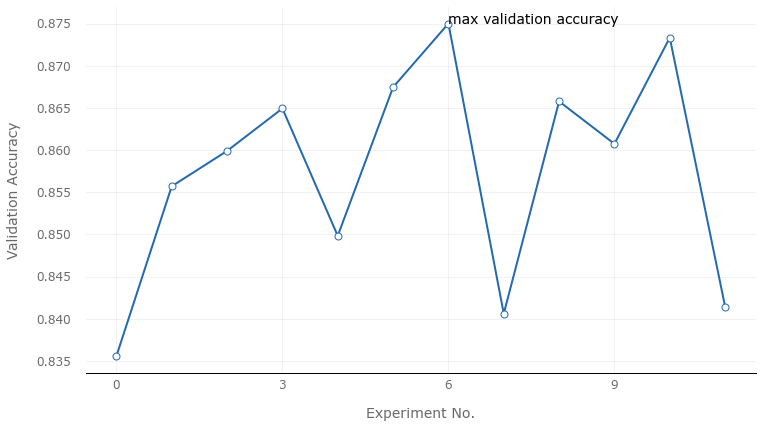

In [ ]:
#See the line plot -> model_index vs validation accuracy 
r.plot_line('val_categorical_accuracy')
plt.xlabel('Experiment No.')
plt.ylabel('Validation Accuracy')
plt.annotate( 'max validation accuracy', (model_index, val_acc))
plt.show()

In [ ]:
#See the result of best student for different temperature and alpha
r.data.iloc[[model_index]]

,round_epochs,categorical_accuracy,student_loss,distillation_loss,combined_loss,val_categorical_accuracy,val_student_loss,alpha,temperature
6,30,1.0,0.033203,0.034761,0.034294,0.875,1.373999,0.3,5


In [ ]:
#Create best Student
best_student = model_from_json(scan_object.saved_models[model_index])
weights = scan_object.saved_weights[model_index]
best_student.set_weights(weights)

best_student.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

#Load teacher
temp_teacher = get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME)
temp_teacher.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

print("Evaluating Student on test dataset\n")
test_generator = get_generator(x_test, y_test, mobilenet_v2.preprocess_input, shuffle=False)
s_acc = best_student.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

print("\nEvaluating Teacher on test dataset\n")
test_generator = get_generator(x_test, y_test, efficientnet.preprocess_input, shuffle=False)
t_acc = temp_teacher.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

Evaluating Student on test dataset

199/199 [==============================] - 16s 12ms/step - loss: 0.6369 - categorical_accuracy: 0.8860

Evaluating Teacher on test dataset

199/199 [==============================] - 41s 85ms/step - loss: 0.2800 - categorical_accuracy: 0.9386


**Saving Model**

In [ ]:
print("MODEL AND HISTORY SAVED")
#save models
save_m(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, best_student)

#save history
distiller_history = scan_object.round_history[model_index]
save_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, distiller_history)

MODEL AND HISTORY SAVED


**Final Results**

In [ ]:
student_acc = "{0:.3f} ".format(s_acc[1]*100)
student_size = "{0:.2f} M".format(best_student.count_params()/10**6)
student_flops = "{0:.2f} G".format(get_flops(Model(best_student.input, best_student.output), batch_size=1)/ 10 ** 9)

teacher_acc = "{0:.3f} ".format(t_acc[1]*100)
teacher_size = "{0:.2f} M".format(temp_teacher.count_params()/10**6)
teacher_flops = "{0:.2f} G".format(get_flops(Model(temp_teacher.input, temp_teacher.output), batch_size=1)/ 10 ** 9)

results = {STUDENT_NAME:{'Test Accuracy(%)':student_acc,
                         'Parameters':student_size,
                         'FLOPs':student_flops},
           TEACHER_NAME:{'Test Accuracy(%)':teacher_acc,
                         'Parameters':teacher_size,
                         'FLOPs':teacher_flops}}

results = pd.DataFrame(results)
results

,KD-MobileNetV2,EfficientNetB7
Test Accuracy(%),87.788,92.932
Parameters,2.51 M,64.61 M
FLOPs,0.80 G,13.69 G


# **Training Visualization**

In [8]:
#VISUAL CUSTOMIZER
distiller_history = load_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME)

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10
fontsize = 7

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


**Accuracy Curve**

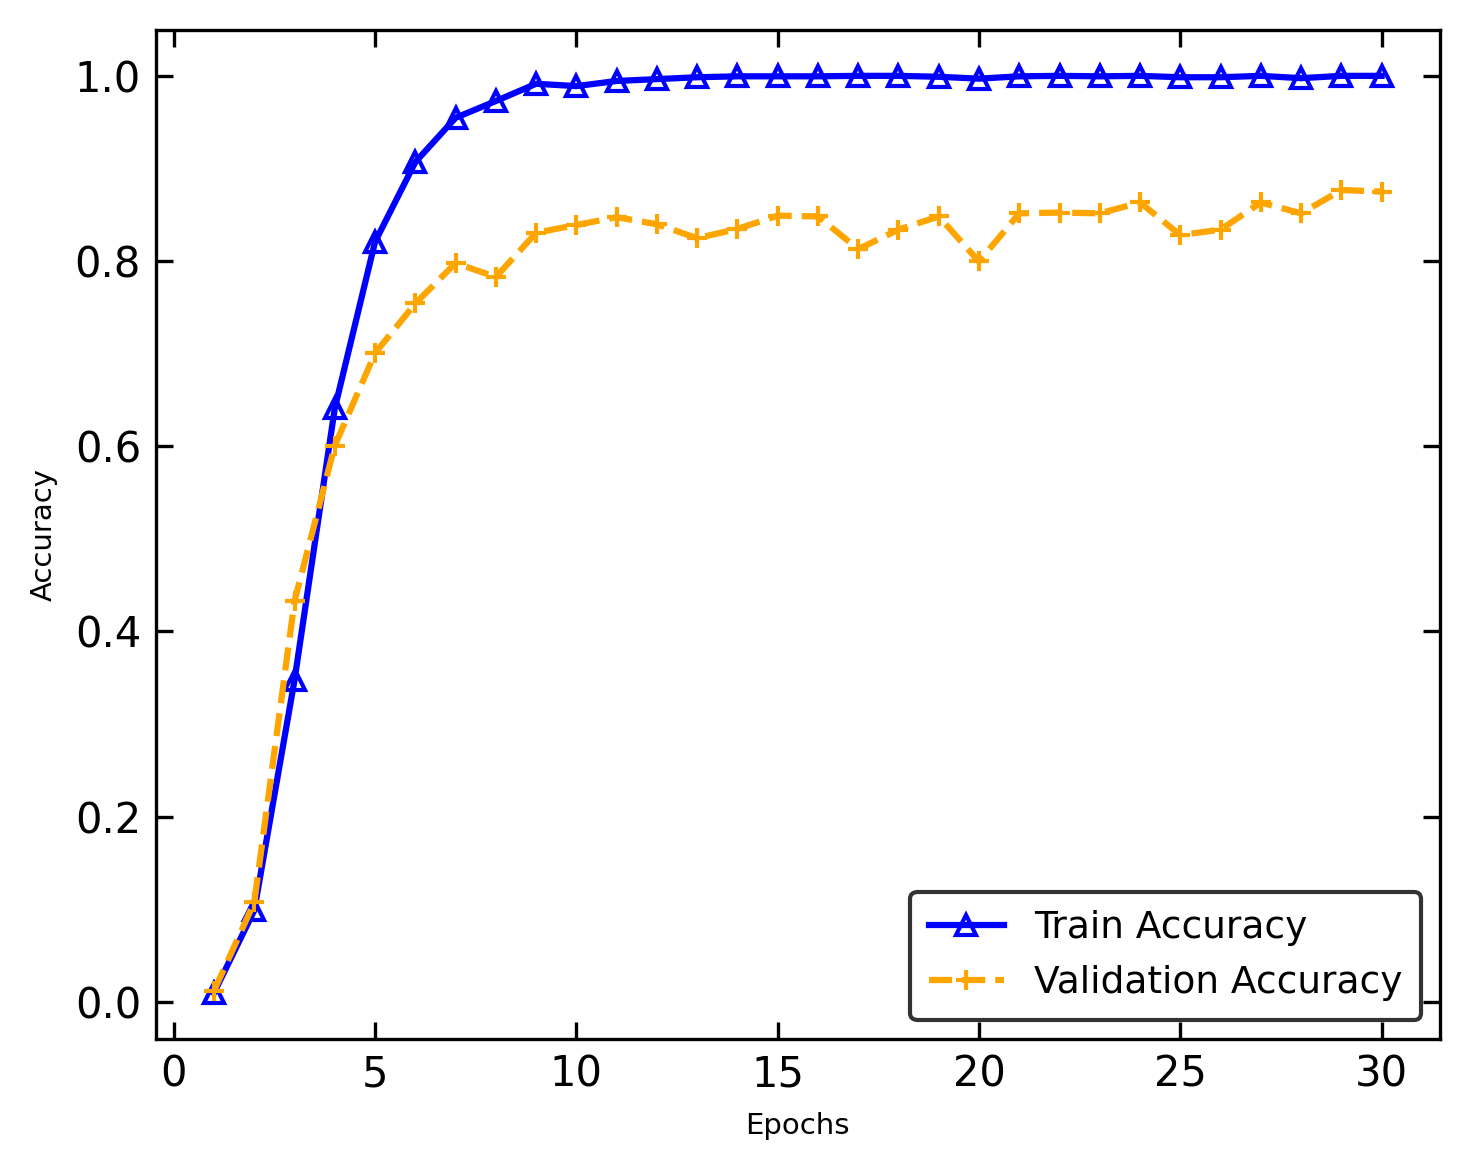

In [9]:
#PRINTS THE ACCURACY GROWTH
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in") 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), distiller_history["categorical_accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), distiller_history["val_categorical_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Accuracy", fontsize=fontsize, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()

**Loss Curve**

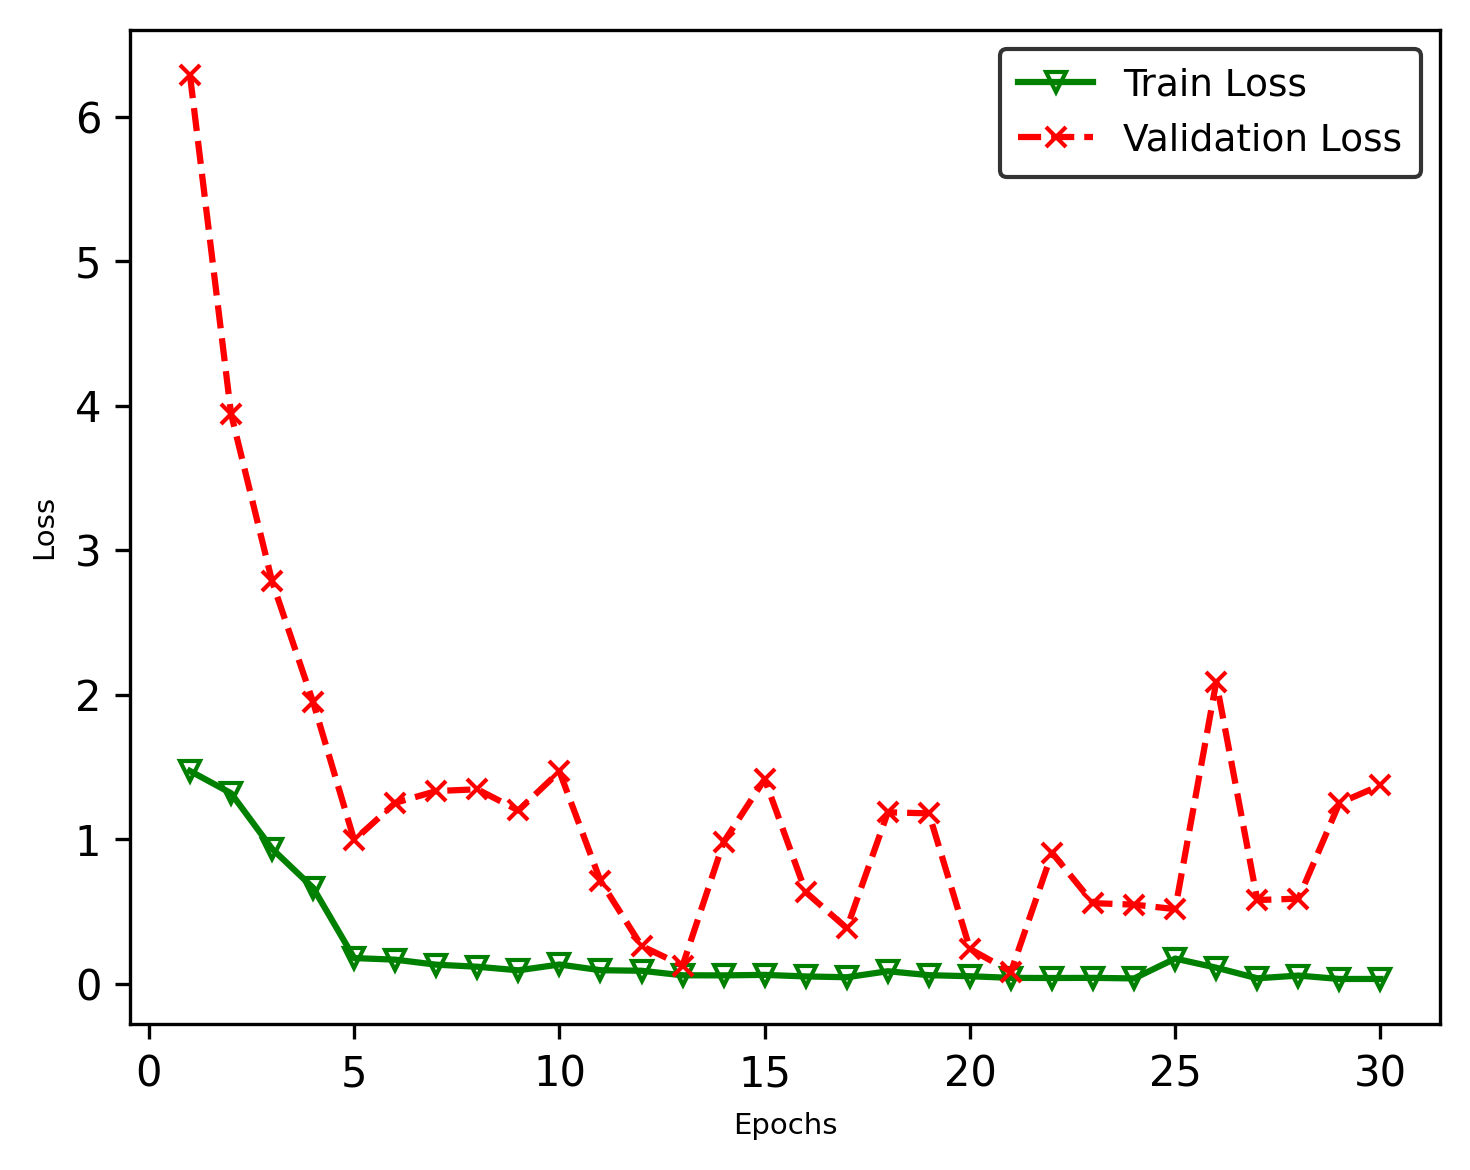

In [10]:
#PRINTS THE DECREASE OF LOSS
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.arange(1, N+1), distiller_history["combined_loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), distiller_history["val_student_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v, label="Validation Loss")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Loss", fontsize=fontsize, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()